In [1]:
import tensorflow as tf
import instaloader
import cv2
from sentiment import SentimentAnalyser
import numpy as np
import os
import math

In [2]:
folder = 'Data'

In [3]:
se = SentimentAnalyser()

[nltk_data] Downloading package names to
[nltk_data]     C:\Users\kapsu\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kapsu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\kapsu\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\kapsu\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\kapsu\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kapsu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is alr

In [4]:
L = instaloader.Instaloader()

In [5]:
def read_data(folder: str = "Data/Data", metadata_ext: str = ".json.xz"):

    images = []
    numeric = []
    output = []
    
    count = 0

    for inner_folder in os.listdir(folder):
        
        if count % 100 == 0:
            print(f'read {count} rows')
            
        count += 1

        files_in_folder = os.listdir(folder + "/" + inner_folder)

        image_files = 0

        for files in files_in_folder:
            if (
                files.endswith(".png")
                or files.endswith(".jpg")
                or files.endswith(".jpeg")
            ):
                image_files += 1
        # print(f"images: {image_files}")

        for filename in os.listdir(folder + "/" + inner_folder):

            if filename.endswith(metadata_ext):
                post_node = instaloader.structures.load_structure_from_file(
                    L.context, os.path.join(folder, inner_folder, filename)
                )

                post_likes = post_node.likes
                post_comments = post_node.comments

                profile_followers = post_node.owner_profile.followers

                post_caption = post_node.caption

                try:
                    score_full = se.get_score(post_caption)
                    score = score_full["compound"]
                except Exception:
                    score = 0

                for _ in range(image_files):
                    output.append(
                        np.array(
                            [
                                post_likes / profile_followers,
                                post_comments / profile_followers,
                            ]
                        )
                    )

                    numeric.append(score)

                continue

            img = cv2.imread(os.path.join(folder, inner_folder, filename))

            if img is not None:
                imgf = cv2.resize(img, (256, 256))
                # print(f"{img.shape} -> {imgf.shape}")
                images.append(imgf)

    img_arr = np.array(images)
    numeric_arr = np.array(numeric)
    output_arr = np.array(output)

    return (img_arr, numeric_arr, output_arr)

In [6]:
data = read_data()

x_image= np.array(data[0])
x_numerical = np.array(data[1])
y = np.array(data[2])

read 0 rows
read 100 rows
read 200 rows
read 300 rows
read 400 rows
read 500 rows
read 600 rows
read 700 rows
read 800 rows
read 900 rows
read 1000 rows
read 1100 rows
read 1200 rows
read 1300 rows
read 1400 rows
read 1500 rows
read 1600 rows
read 1700 rows
read 1800 rows
read 1900 rows
read 2000 rows
read 2100 rows


In [7]:
indices = np.random.permutation(x_image.shape[0])

In [8]:
ratio = math.floor(x_image.shape[0]*0.8)
ratio

4750

In [9]:
train_idx, test_idx = indices[:ratio],indices[ratio:]

In [10]:
x_image_train,x_image_test= x_image[train_idx],x_image[test_idx]

In [11]:
x_numerical_train, x_numerical_test = x_numerical[train_idx],x_numerical[test_idx]

In [12]:
y_train, y_test = y[train_idx],y[test_idx]

In [13]:
x_image_train.shape

(4750, 256, 256, 3)

In [14]:
x_numerical_train.shape

(4750,)

In [15]:
x_numerical_train[:10]

array([ 0.    , -0.2714,  0.9378,  0.6169,  0.989 ,  0.9488,  0.5106,
        0.7506,  0.7883,  0.9944])

In [16]:
y_train.shape

(4750, 2)

In [17]:
# Define the input layers
numerical_input = tf.keras.layers.Input(shape=(1,))
image_input = tf.keras.layers.Input(shape=(256, 256, 3))

In [18]:
# Define the numerical input processing layer
numerical_layer = tf.keras.layers.Dense(12, activation='relu')(numerical_input)

In [19]:
# Define the image input processing layers
image_layer = tf.keras.layers.Conv2D(128, (16, 16), activation='relu')(image_input)
image_layer = tf.keras.layers.MaxPooling2D(pool_size=(12, 12))(image_layer)
image_layer = tf.keras.layers.Flatten()(image_layer)

In [20]:
# Concatenate the processed inputs
concatenated_inputs = tf.keras.layers.concatenate([numerical_layer, image_layer])

In [21]:
# Define the output layer
output_layer = tf.keras.layers.Dense(2)(concatenated_inputs)

In [22]:
# Define the model
model = tf.keras.models.Model(inputs=[numerical_input, image_input], outputs=output_layer)

In [23]:
# Compile the model
model.compile(optimizer='adam', loss='mse')

In [24]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

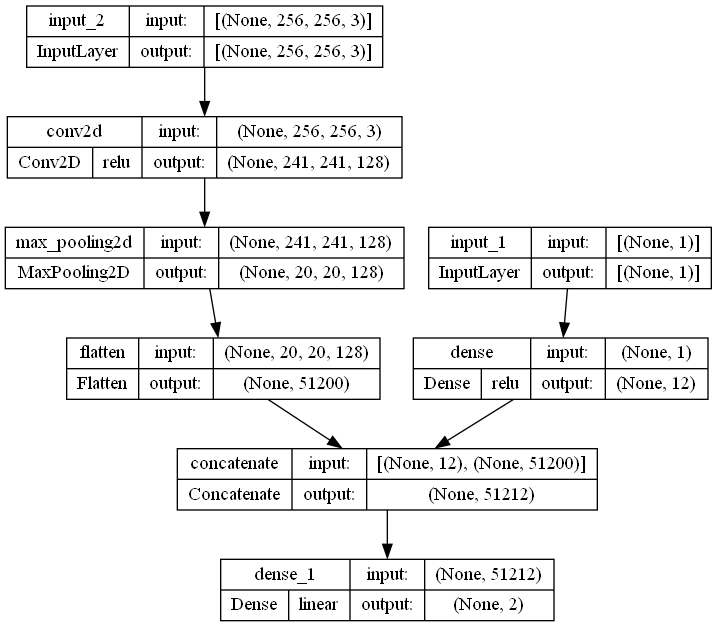

In [25]:
tf.keras.utils.plot_model(
model,
to_file="model.png",
show_shapes=True,
show_dtype=False,
show_layer_names=True,
rankdir="TB",
expand_nested=True,
dpi=96,
layer_range=None,
show_layer_activations=True,
)

In [26]:
model_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)

In [27]:
# Train the model
model.fit([x_numerical_train, x_image_train], y_train, epochs=10, batch_size=64, callbacks=model_callback,use_multiprocessing=True)

Epoch 1/10
75/75 [==============================] - ETA: 0s - loss: 136244.9219 
Epoch 1: saving model to training_1\cp.ckpt
75/75 [==============================] - 1338s 18s/step - loss: 136244.9219
Epoch 2/10
75/75 [==============================] - ETA: 0s - loss: 0.3247 
Epoch 2: saving model to training_1\cp.ckpt
75/75 [==============================] - 951s 13s/step - loss: 0.3247
Epoch 3/10
75/75 [==============================] - ETA: 0s - loss: 0.2374 
Epoch 3: saving model to training_1\cp.ckpt
75/75 [==============================] - 942s 13s/step - loss: 0.2374
Epoch 4/10
75/75 [==============================] - ETA: 0s - loss: 0.1323 
Epoch 4: saving model to training_1\cp.ckpt
75/75 [==============================] - 944s 13s/step - loss: 0.1323
Epoch 5/10
75/75 [==============================] - ETA: 0s - loss: 0.0832 
Epoch 5: saving model to training_1\cp.ckpt
75/75 [==============================] - 1037s 14s/step - loss: 0.0832
Epoch 6/10
75/75 [====================

In [28]:
model.evaluate([x_numerical_test,x_image_test],y_test)

38/38 [==============================] - 86s 2s/step - loss: 0.1671


0.16705937683582306

In [31]:
model.save('models/insta')

INFO:tensorflow:Assets written to: models/insta\assets


INFO:tensorflow:Assets written to: models/insta\assets


In [37]:
model2 = tf.keras.models.load_model('models/insta/')

In [38]:
model2.evaluate([x_numerical_test,x_image_test],y_test)

38/38 [==============================] - 78s 2s/step - loss: 0.1671


0.16705937683582306